# CoVid-19 Pandemic Statistics

Analysis of the CoVid-19 outbreak in Italy.

Total population of some Italian regions of interest extracted from: https://www.tuttitalia.it/regioni/popolazione

An analysis by CNR (in Italian): https://www.cnr.it/it/nota-stampa/n-9281/analisi-numerica-dei-dati-relativi-alla-diffusione-del-covid-19-in-italia-e-nel-mondo

In [1]:
from datetime import datetime,timedelta
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
# Total population of some Italian regions
pop = {}
pop['Lombardia'] = 10
pop['Veneto'] = 4.9
pop['Emilia Romagna'] = 4.4
pop['Piemonte'] = 4.3
pop['Marche'] = 1.5
pop['Sicilia'] = 5
pop['Campania'] = 5.8
pop['Calabria'] = 1.9

In [3]:
# This is the Github repo with the Italian detailed data
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province.csv'
df = pd.read_csv(url)
df[df.denominazione_provincia == 'Palermo'].tail()

,data,stato,codice_regione,denominazione_regione,codice_provincia,denominazione_provincia,sigla_provincia,lat,long,totale_casi,note_it,note_en
3681,2020-03-23T17:00:00,ITA,19,Sicilia,82,Palermo,PA,38.115697,13.362357,109,NaN,NaN
3809,2020-03-24T17:00:00,ITA,19,Sicilia,82,Palermo,PA,38.115697,13.362357,170,NaN,NaN
3937,2020-03-25T17:00:00,ITA,19,Sicilia,82,Palermo,PA,38.115697,13.362357,193,NaN,NaN
4065,2020-03-26T17:00:00,ITA,19,Sicilia,82,Palermo,PA,38.115697,13.362357,205,NaN,NaN
4193,2020-03-27T17:00:00,ITA,19,Sicilia,82,Palermo,PA,38.115697,13.362357,218,NaN,NaN


In [4]:
df.describe()

,codice_regione,codice_provincia,lat,long,totale_casi
count,4224.000000,4224.000000,4224.000000,4224.000000,4224.000000
mean,10.140625,207.523438,35.868843,10.112000,193.044034
std,5.915108,347.424156,16.073427,5.098196,601.930655
min,1.000000,1.000000,0.000000,0.000000,0.000000
25%,5.000000,32.750000,38.848542,8.583304,0.000000
50%,9.000000,64.500000,42.609815,11.188560,15.000000
75%,15.250000,96.250000,44.947714,13.593962,123.250000
max,20.000000,999.000000,46.499335,18.171897,8060.000000


In [5]:
### Some data manipulation. Refer to https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas

regdf = {}
for r in pop:
  # sum over all provinces for a given date ('data')
  # + rename data -> date, totale_casi -> region name
  regdf[r] = df[df['denominazione_regione'] == r].groupby('data')[['totale_casi']].sum() \
             .reset_index() \
             .rename(columns={'data': 'date', 'totale_casi': r})

  # convert date format to days since Feb 29th
  regdf[r]['date'] = regdf[r]['date'].map(lambda d : \
        (datetime.strptime(d, '%Y-%m-%dT%H:%M:%S') - datetime.strptime('2020-02-29','%Y-%m-%d')).days)

  # convert #cases to cases per 1M inhabitants
  regdf[r][r] /= pop[r]

regdf['Lombardia'].tail()

,date,Lombardia
28,23,2876.1
29,24,3070.3
30,25,3234.6
31,26,3488.9
32,27,3729.8


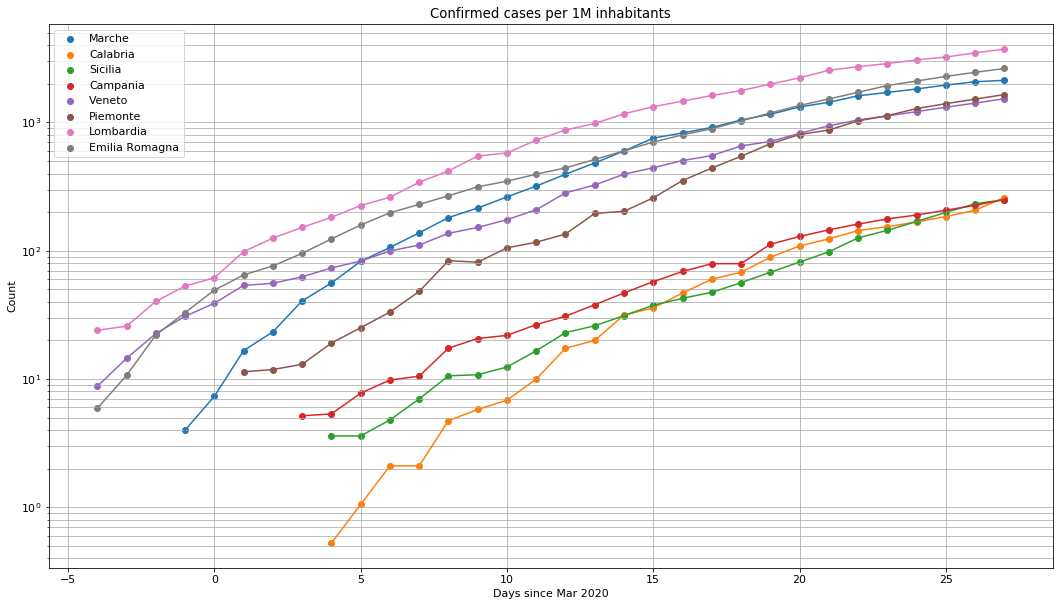

In [6]:
plt.rcParams['figure.figsize'] = [18, 10]
plt.rc('font', size=11)

for r in pop:
  # drop first days as the data is noisy: keep after value > 2 cases / 1M people
  regdf[r] = regdf[r][regdf[r].gt(3).any(axis=1)]

  # get all data points
  t = list(regdf[r].iloc[:, 0]) 
  y = list(regdf[r].iloc[:, 1])
  plt.scatter(t, y, label=r)   # draw the dots
  plt.plot(t, y)   # draw the lines

plt.legend()
plt.title("Confirmed cases per 1M inhabitants")
plt.xlabel("Days since Mar 2020")
plt.ylabel("Count")
plt.yscale('log')
plt.grid(which='both')
plt.show()

# Models and curves fitting

Now let's create the two curves and fit the data to both (cf. Europe notebook):
* The exponential fit
* The "logistic" fit

In [7]:
def exp_model(t, a, b, tau):
  return a*np.exp((t-b)/tau)

def logistic_model(t, a, b, tau):
  return a/(1+np.exp(-(t-b)/tau))

In [8]:
logit_fit = {}
exp_fit = {}
for r in pop:
  t = list(regdf[r].iloc[:,0])
  y = list(regdf[r].iloc[:,1])
  try:
    exp_fit[r] = curve_fit(exp_model, t, y, p0=[0.01, 0.5, 3])
  except RuntimeError:
    exp_fit[r] = None
    pass
  try:
    logit_fit[r] = curve_fit(logistic_model, t, y, p0=[100000, 40, 3])
  except RuntimeError:
    logit_fit[r] = None
logit_fit

{'Calabria': None,
 'Campania': None,
 'Emilia Romagna': (array([4520.70836759,   24.9237074 ,    5.85272732]),
  array([[2.84696911e+04, 7.27175902e+01, 1.73626081e+01],
         [7.27175902e+01, 1.87738583e-01, 4.56037049e-02],
         [1.73626081e+01, 4.56037049e-02, 1.26196378e-02]])),
 'Lombardia': (array([4759.29617471,   20.53977   ,    5.44169079]),
  array([[1.73122853e+04, 4.55417765e+01, 1.59844258e+01],
         [4.55417765e+01, 1.23374836e-01, 4.30664944e-02],
         [1.59844258e+01, 4.30664944e-02, 1.86611149e-02]])),
 'Marche': (array([2539.36650621,   19.57433511,    4.52666233]),
  array([[2.59095514e+03, 1.13822339e+01, 4.75707970e+00],
         [1.13822339e+01, 5.29039463e-02, 2.13157387e-02],
         [4.75707970e+00, 2.13157387e-02, 1.16225152e-02]])),
 'Piemonte': (array([2130.75257795,   22.31648975,    3.9783062 ]),
  array([[3.79884134e+03, 1.63747268e+01, 5.76896394e+00],
         [1.63747268e+01, 7.27708120e-02, 2.54693917e-02],
         [5.76896394e+00, 2

In [9]:
tdoubling = {}
for r in pop:
  tdoubling[r] = int(10*exp_fit[r][0][2]*np.log(2))/10.0
tdoubling

{'Calabria': 4.6,
 'Campania': 5.5,
 'Emilia Romagna': 5.9,
 'Lombardia': 6.7,
 'Marche': 6.3,
 'Piemonte': 4.9,
 'Sicilia': 4.2,
 'Veneto': 6.1}

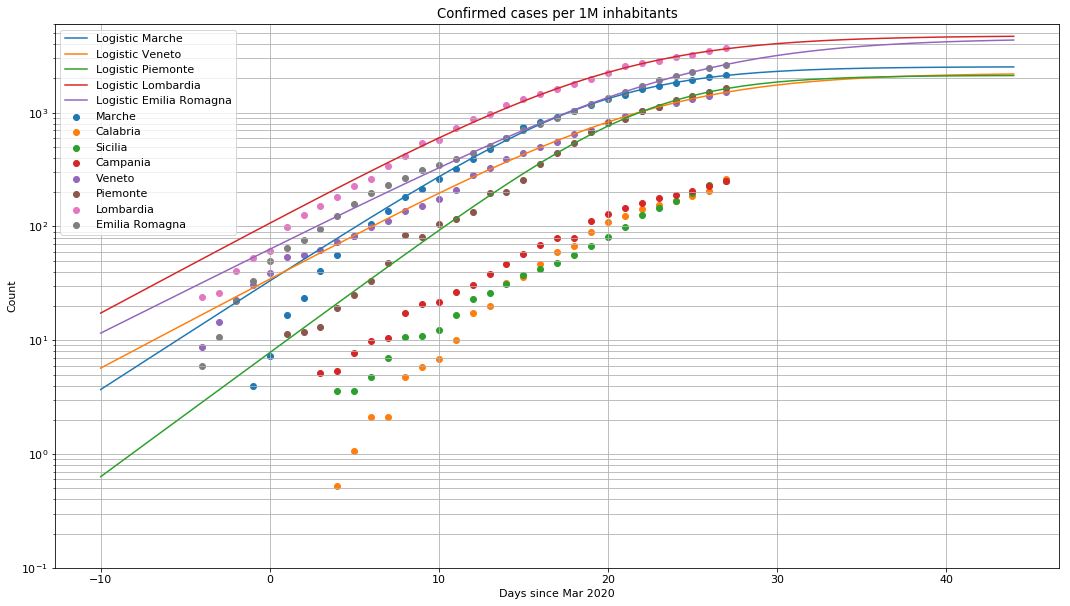

In [10]:
t_fit = list(range(-10, +45))

show_exp = False

for r in pop:
  # Real data
  t = list(regdf[r].iloc[:, 0])
  y = list(regdf[r].iloc[:, 1])
  plt.scatter(t, y, label=r)

  # Predicted logistic curve
  if not show_exp and logit_fit[r]:
    plt.plot(t_fit, [logistic_model(i, logit_fit[r][0][0],logit_fit[r][0][1],logit_fit[r][0][2]) for i in t_fit],
             label=("Logistic %s" % r))

  # Predicted exponential curve
  if show_exp and exp_fit[r]:
    plt.plot(t_fit, [exp_model(i, exp_fit[r][0][0],exp_fit[r][0][1],exp_fit[r][0][2]) for i in t_fit],
             label=("Exponential %s" % r))

plt.legend()
plt.title("Confirmed cases per 1M inhabitants")
plt.xlabel("Days since Mar 2020")
plt.ylabel("Count")
plt.ylim((0.1, 6e3))
plt.yscale('log')
plt.grid(which='both')
plt.show()